In [1]:
import os
import pickle

# import the package needed to solve the environnement
from scipy.optimize import linear_sum_assignment #hungarian matching algorithm
import numpy as np
from scipy.stats import beta, bernoulli,norm
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.distributions.empirical_distribution import ECDF

# Z GRAPH

In [2]:
# Create the bipartite graph matching environnement
class zgraph():
    """
    create the bp graph used in the experiment. Can be improved to receive graph parameter if needed
    n is the number of vertex of the first groupe
    
    sample from a random variable of law bernoulli, or gaussian 
    
    """ 
    def __init__(self,m,random_variable = "bernoulli",delta = 0.9):
        self.d = m**2
        self.m = m
        self.random_variable = random_variable
        self.delta = delta
        
        #adjacency matrix
        self.adjacency_matrix = np.eye(m)+ np.eye(m,k=1)
        self.adjacency_matrix[m-1,0] = 1
        
        self.weight_matrix = np.eye(m)+ np.eye(m,k=1)*(1-delta)
        self.weight_matrix[m-1,0] = 1-delta
                   
    def draw(self, arm_played):
        """
        Draw a vector of reward in a dict
        Also return the regret of that choice
        
        """
        reward_dict = dict()
        regret = self.m
        # we assume for the moment that all arm are independent
        for i in arm_played:
            if self.adjacency_matrix[tuple(i)] == 1:
                if self.random_variable == "bernoulli":
                    reward_dict[tuple(i)] = bernoulli.rvs(self.weight_matrix[tuple(i)])
                elif self.random_variable == "gaussian":
                    reward_dict[tuple(i)] = norm.rvs(self.weight_matrix[tuple(i)])


                regret -= self.weight_matrix[tuple(i)]
            
        return reward_dict, regret

# TS

In [6]:
class zCThompson_sampling():
    """
    Only for the Z graph bipartite matching
    """
    def __init__(self, m, random_variable = "beta",n_init = 0,weight_matrix = None):
        
        self.iteration = 0
        self.m = m
        self.d = m**2
        self.weight_matrix = weight_matrix
        
        
        self.random_variable = random_variable
        self.post_param = dict()
        self.playhist = []
        self.number_item_played = dict()
        self.initialization = False
        
        self.n_init = n_init
        if self.n_init > 0:   
            self.initialization = True
        
        self.iteration = 0
        # Construct the dictionnary of parameter (could store all the parameter in a matrix n*n*2) 
        # but here for being more modulable it will be on 
        for i in range(m):
            for j in range(m):
                if j == 1+i or j==i: 
                    if self.random_variable == "beta":
                        self.post_param[i,j] = np.array([1.,1.]) # prior is 1,1 for the beta law of each arm
                    elif self.random_variable == "gaussian": 
                        self.post_param[i,j] = np.array([0.,0.])
                    self.number_item_played[i,j] = 0.
                elif i==self.m-1 and j==0:
                    if self.random_variable == "beta":
                        self.post_param[i,j] = np.array([1.,1.]) # prior is 1,1 for the beta law of each arm
                    elif self.random_variable == "gaussian": 
                        self.post_param[i,j] = np.array([0.,0.])
                    self.number_item_played[i,j] = 0.
                else:     
                    self.post_param[i,j] = [False]
                    self.number_item_played[i,j] = [False]
                    
                self.number_item_played[i,j] = 0.
        
        
        self.weight_draw = np.zeros((m,m))
         
    def reset(self):
        self.weight_draw = np.zeros((self.m,self.m))
        for i in range(self.m):
            for j in range(self.m):
                if j == 1+i or j == i: 
                    if self.random_variable == "beta":
                        self.post_param[i,j] = np.array([1.,1.]) # prior is 1,1 for the beta law of each arm
                    elif self.random_variable == "gaussian": 
                        self.post_param[i,j] = np.array([0.,0.])
                    self.number_item_played[i,j] = 0.
                elif j==0 and i==self.m-1:
                    if self.random_variable == "beta":
                        self.post_param[i,j] = np.array([1.,1.]) # prior is 1,1 for the beta law of each arm
                    elif self.random_variable == "gaussian": 
                        self.post_param[i,j] = np.array([0.,0.])
                    self.number_item_played[i,j] = 0.
                else:     
                    self.post_param[i,j] = [False]
                    self.number_item_played[i,j] = [False]
                    
                self.number_item_played[i,j] = 0.
        
        
        
        
    def play(self):
        """
        This will draw a sample (arm played) using the parameters 

        """
        self.iteration +=1
        self.weight_draw = np.zeros((self.m,self.m))
        
        for i in range(self.m):
            for j in range(self.m):
                if self.post_param[(i,j)][0]:
                    if self.random_variable == "beta":
                            self.weight_draw[i,j] = beta.rvs(self.post_param[(i,j)][0],self.post_param[(i,j)][1])
                            
                    elif self.random_variable == "gaussian": 
                        self.weight_draw[i,j] = norm.rvs(self.post_param[(i,j)][0],self.post_param[(i,j)][1])
                    


        row_ind, col_ind = linear_sum_assignment(-self.weight_draw) 
        # we have to maximize the reward (the scypy implementation minimizes the cast)

        arm_played = np.concatenate([row_ind[:,None], col_ind[:,None]],axis=1)
        #Trick to have the list of the arm played
        
        self.playhist.append(arm_played)

        return arm_played


    def update(self, observation):
        """
        update the parameter of the arms
        observation are a dictionary of reward
        """
        for key, valu in observation.items():
            self.number_item_played[key] += 1
            if  self.post_param[key][0]:
                if self.random_variable == "beta":
                    y = bernoulli.rvs(valu)
                    self.post_param[key][0] += y  #alpha update
                    self.post_param[key][1] += 1-y  #beta update
                elif self.random_variable == "gaussian": 
                    self.post_param[key][0] = (self.post_param[key][0]*(self.number_item_played[key]-1)+valu)/self.number_item_played[key]
                    self.post_param[key][1] = 1/np.sqrt(self.number_item_played[key])

# CUCB

In [39]:
class zCUCB():
    """
    Only for the bipartite matching (for the moment)
    """
    def __init__(self, m,n_init = 0, eps = 10^-8):
        
        self.iteration = 0
        self.m = m
        self.d = m**2
        self.eps = eps
        
        self.initialization = False
        
        self.random_variable = random_variable
        self.mu = dict()
        self.playhist = []
        self.number_item_played = dict()
        
        self.n_init = n_init
        if self.n_init > 0:   
            self.initialization = True
        
        self.iteration = 0
        # Construct the dictionnary of parameter (could store all the parameter in a matrix n*n*2) 
        # but here for being more modulable it will be on 
        for i in range(self.m):
            for j in range(self.m):
                if j == 1+i or j == i: 
                    self.mu[i,j] = np.array([self.eps]) 
                    self.number_item_played[i,j] = 0.
                elif j==0 and i==self.m-1:
                    self.mu[i,j] = np.array([self.eps]) 
                    self.number_item_played[i,j] = 0.
                else:     
                    self.mu[i,j] = [False]
                    self.number_item_played[i,j] = [False]
                    
        
         
    def reset(self):
        for i in range(self.m):
            for j in range(self.m):
                if j == 1+i or j == i: 
                    self.mu[i,j] = np.array([self.eps]) 
                    self.number_item_played[i,j] = 0.
                elif j==0 and i==self.m-1:
                    self.mu[i,j] = np.array([self.eps]) 
                    self.number_item_played[i,j] = 0.
                else:     
                    self.mu[i,j] = [False]
                    self.number_item_played[i,j] = [False]
                    
                self.number_item_played[i,j] = 0.
        
        
        
        
    def play(self):
        """
        This will choose the arm according to the bonus index of CUCB

        """
        
        
        if self.iteration < self.n_init:
            self.iteration +=1
            arm_played = np.concatenate([np.arange(self.m)[:,None],np.arange(self.m)[:,None]],axis = 1)
            return(arm_played)
        
        if self.iteration < 2*self.n_init:
            self.iteration +=1
            row = [self.m-1]+[i for i in range(self.m-1)]
            arm_played = np.concatenate([np.array(row)[:,None],np.arange(self.m)[:,None]],axis = 1)
            return(arm_played)
        else:       
            self.initialization = False
            
            
        self.iteration +=1   
        self.bonus_index = np.zeros((self.m,self.m))
        
        
        for i in range(self.m):
            for j in range(self.m):
                if j == 1+i or j == i: 
                    self.bonus_index[i,j] = self.mu[i,j][0] + np.sqrt(1.5*np.log(self.iteration)/self.number_item_played[i,j])
                elif j==0 and i==self.m-1:
                    self.bonus_index[i,j] = self.mu[i,j][0] + np.sqrt(1.5*np.log(self.iteration)/self.number_item_played[i,j])
        
                
        
        row_ind, col_ind = linear_sum_assignment(-self.bonus_index) 
        # we have to maximize the reward (the scypy implementation minimizes the cast)

        arm_played = np.concatenate([row_ind[:,None], col_ind[:,None]],axis=1)
        #Trick to have the list of the arm played
        
        self.playhist.append(arm_played)

        return arm_played


    def update(self, observation):
        """
        update the parameter of the arms
        observation are a dictionary of reward
        """
        
        for key, valu in observation.items():
            self.number_item_played[key] += 1
            if  self.mu[key][0]:
                    self.mu[key] = (self.mu[key]*(self.number_item_played[key]-1)+valu)/self.number_item_played[key]
                    

# TS First Optimal play 

## Fixed delta

m =  11
begin_trial 0
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 166000
Have still not played the optimal arm at time 168000
Have still not played the optimal arm at time 170000
Have still not played the optimal arm at time 172000
Have still not played the optimal arm at time 174000
Have still not played the optimal arm at time 176000
Have still not played the optimal arm at time 178000
Have still not played the optimal arm at time 180000
Have still not played the optimal arm at time 182000
Have still not played the optimal arm at time 184000
Have still not played the optimal arm at time 186000
Have still not played the optimal arm at time 188000
Have still not played the optimal arm at time 190000
Have still not played the optimal arm at time 192000
Have still not played the optimal arm at time 194000
Have still not played the optimal arm at time 196000
Have still not played the optimal arm at time 198000
Have still not played the optimal arm at time 200000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 476000
Have still not played the optimal arm at time 478000
Have still not played the optimal arm at time 480000
Have still not played the optimal arm at time 482000
Have still not played the optimal arm at time 484000
Have still not played the optimal arm at time 486000
Have still not played the optimal arm at time 488000
Have still not played the optimal arm at time 490000
Have still not played the optimal arm at time 492000
Have still not played the optimal arm at time 494000
Have still not played the optimal arm at time 496000
Have still not played the optimal arm at time 498000
Have still not played the optimal arm at time 500000
Have still not played the optimal arm at time 502000
Have still not played the optimal arm at time 504000
Have still not played the optimal arm at time 506000
Have still not played the optimal arm at time 508000
Have still not played the optimal arm at time 510000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not pla

Have still not played the optimal arm at time 256000
Have still not played the optimal arm at time 258000
Have still not played the optimal arm at time 260000
Have still not played the optimal arm at time 262000
Have still not played the optimal arm at time 264000
Have still not played the optimal arm at time 2000
begin_trial 300
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26

Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 78000
Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 82000
Have still not played the optimal arm at time 84000
Have still not played the optimal arm at time 86000
Have still not played the optimal arm at time 88000
Have still not played the optimal arm at time 90000
Have still not played the optimal arm at time 92000
Have still not played the optimal arm at time 94000
Have still not played the optimal arm at time 96000
Have still not played the optimal arm at time 98000
Have still not played the optimal arm at time 100000
Have still not played the optimal arm at time 102000
Have still not played the optimal arm at time 104000
Have still not played the optimal arm at time 106000
Have sti

Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not play

Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 78000
Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 82000
Have still not played the optimal arm at time 84000
Have still not played the optimal arm at time 86000
Have still not played the optimal arm at time 88000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not play

Have still not played the optimal arm at time 186000
Have still not played the optimal arm at time 188000
Have still not played the optimal arm at time 190000
Have still not played the optimal arm at time 192000
Have still not played the optimal arm at time 194000
Have still not played the optimal arm at time 196000
Have still not played the optimal arm at time 198000
Have still not played the optimal arm at time 200000
Have still not played the optimal arm at time 202000
Have still not played the optimal arm at time 204000
Have still not played the optimal arm at time 206000
Have still not played the optimal arm at time 208000
Have still not played the optimal arm at time 210000
Have still not played the optimal arm at time 212000
Have still not played the optimal arm at time 214000
Have still not played the optimal arm at time 216000
Have still not played the optimal arm at time 218000
Have still not played the optimal arm at time 220000
Have still not played the optimal arm at time 

Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not p

Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not playe

Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still n

Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not play

Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 78000
Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 82000
Have still not played the optimal arm at time 84000
Have still not played the optimal arm at time 86000
Have still not played the optimal arm at time 88000
Have still not played the optimal arm at time 90000
Have still not played the optimal arm at time 92000
Have still not played the optimal arm at time 94000
Have still not played the optimal arm at time 96000
Have still not played the optimal arm at time 98000
Have still not played the optimal arm at time 100000
Have still 

Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not pla

Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still no

Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
begin_trial 100
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still 

Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
begin_trial 900
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not

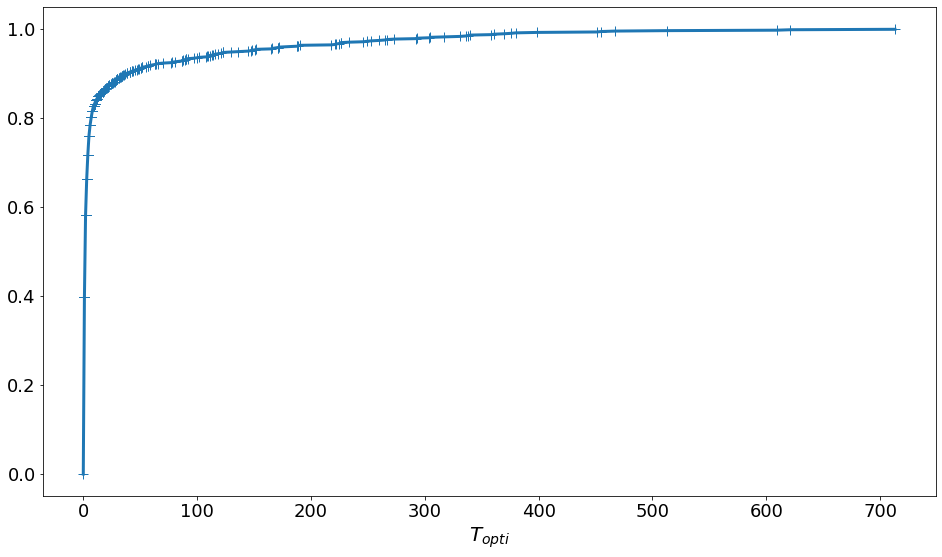

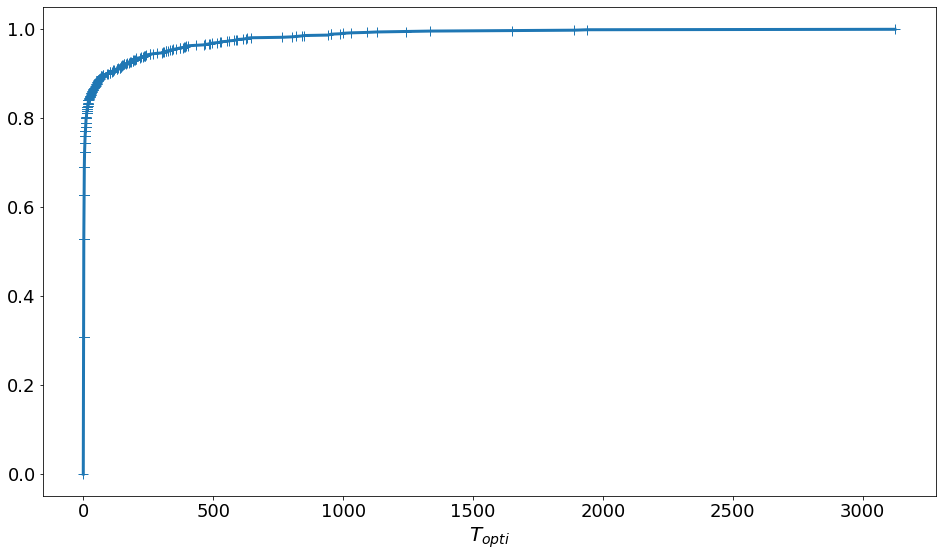

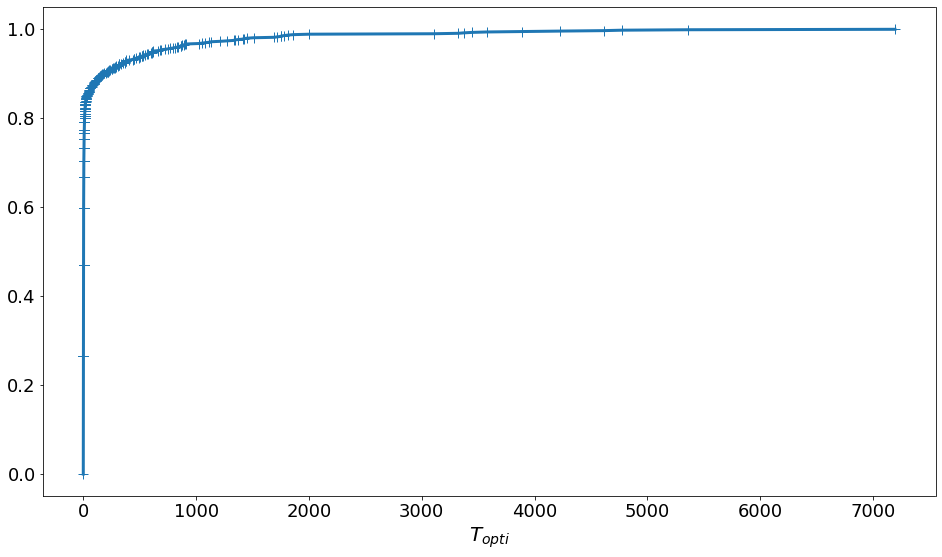

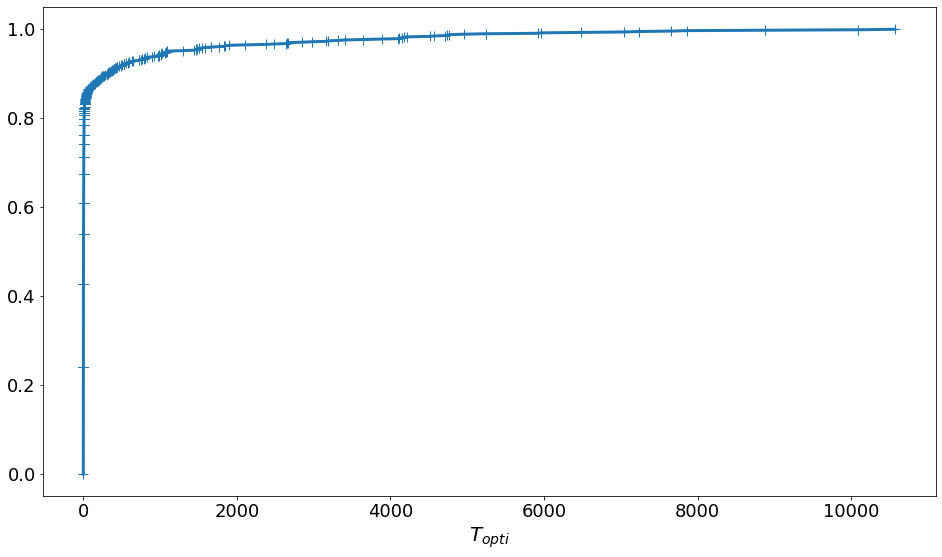

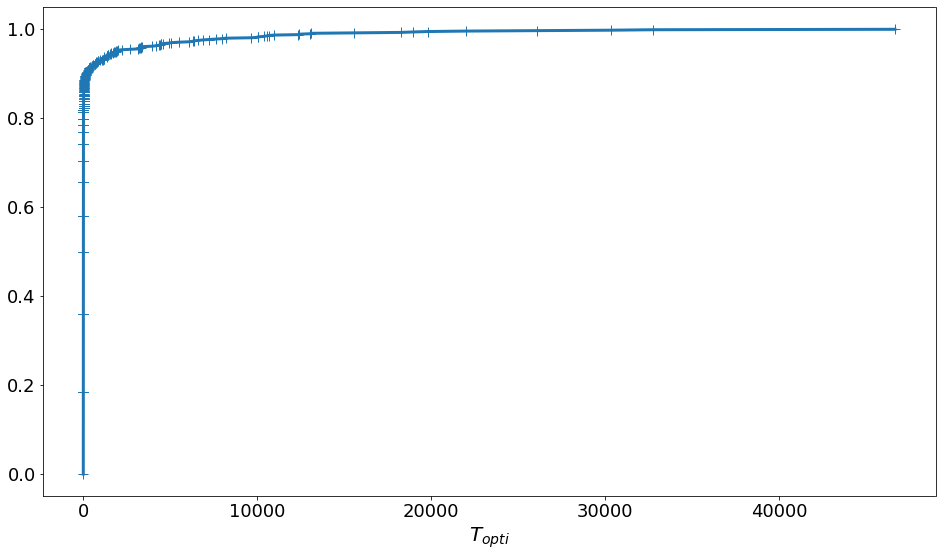

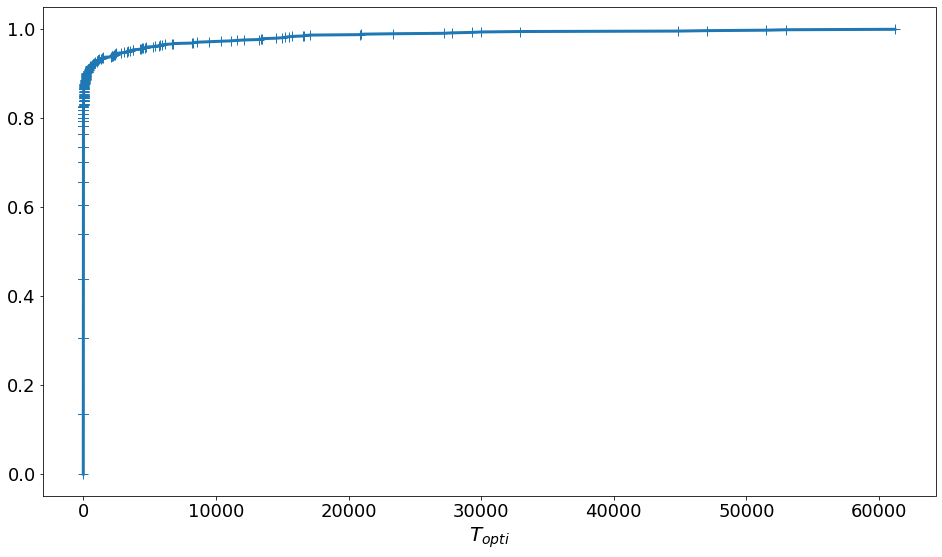

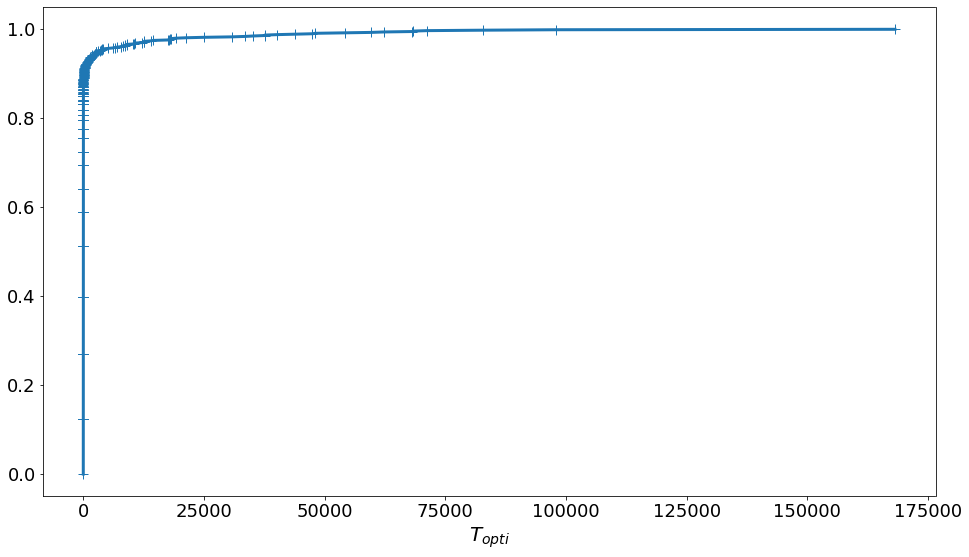

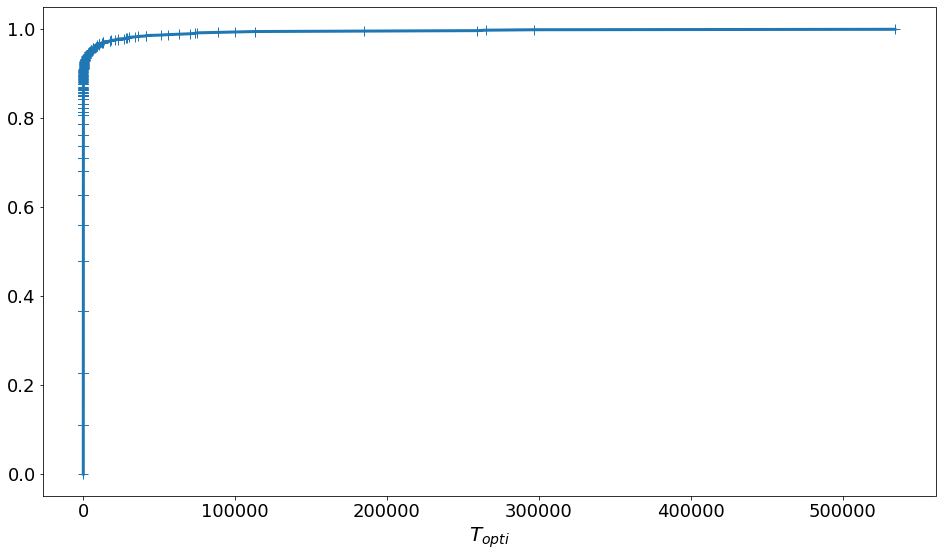

In [14]:
# testing the first time optimal is played

# Params
jump = 1
ms = list(range(4,12,jump))
n_trial = 1000 
delta = 0.15
n_init = 0
random_variable = "bernoulli"
post_distrib = "beta"

Param_dict = {}

Param_dict["ms"] = ms
Param_dict["n_trial"] = n_trial
Param_dict["delta"] = delta
Param_dict["random_variable"] = random_variable
Param_dict["post_distrib"] = post_distrib

upper_limit = 20000000

# Save Folder
experimentfolder = "Experience_opti_{}_{}_{}_delta{:.3f}".format(ms[0],ms[-1],jump,delta)

if not os.path.exists(experimentfolder):
    os.makedirs(experimentfolder)

f = open(experimentfolder + "\\params.pkl","wb")
pickle.dump(Param_dict,f)
f.close()

distrib_first_optimal = [[] for m in ms]


for i,m in enumerate(ms[::-1]):
    print("m = ",m) 
    optimal_arm = np.concatenate([np.arange(m)[:,None],np.arange(m)[:,None]],axis = 1)
    
    
    for iteration in range(n_trial):
        if iteration%100 == 0:
            print("begin_trial {}".format(iteration))
        
        optimal_arm_played = False

        env = zgraph(m, delta = delta)
        player = zCThompson_sampling(m,n_init = n_init)

        counter = 0
        while player.initialization:
                decision = player.play()
                reward_dict, regret = env.draw(decision)
                player.update(reward_dict)
        
        while not optimal_arm_played and counter < upper_limit:
                decision = player.play()
                reward_dict, regret = env.draw(decision)
                player.update(reward_dict)
                counter += 1

                if counter%2000 == 0:
                    print("Have still not played the optimal arm at time {}".format(counter))
                    
                if (decision == optimal_arm).all():
                    optimal_arm_played = True

        distrib_first_optimal[-(i+1)].append(counter)   

np.save(experimentfolder +"\\Distribution",distrib_first_optimal)

#plot Result ECDF

for i,m in enumerate(ms):
    plt.figure(i,figsize = (16,9))
    plt.clf()
    cdf = ECDF(distrib_first_optimal[i])
    plt.plot([0]+list(np.sort(distrib_first_optimal[i])),[0]+list(cdf(np.sort(distrib_first_optimal[i]))),"+-",linewidth=3,markersize=10)
#plt.title("Distribution of first optimal play  for b = {:.1f} and d = {:d} ".format(b,d),fontsize=20)   
    plt.xlabel(r'$T_{opti}$', fontsize=20)
    plt.tick_params(axis='x', labelsize=18)
    plt.tick_params(axis='y', labelsize=18)
    
    plt.savefig(experimentfolder+'\\ECDF_m{}_l{}.pdf'.format(m,n_init))

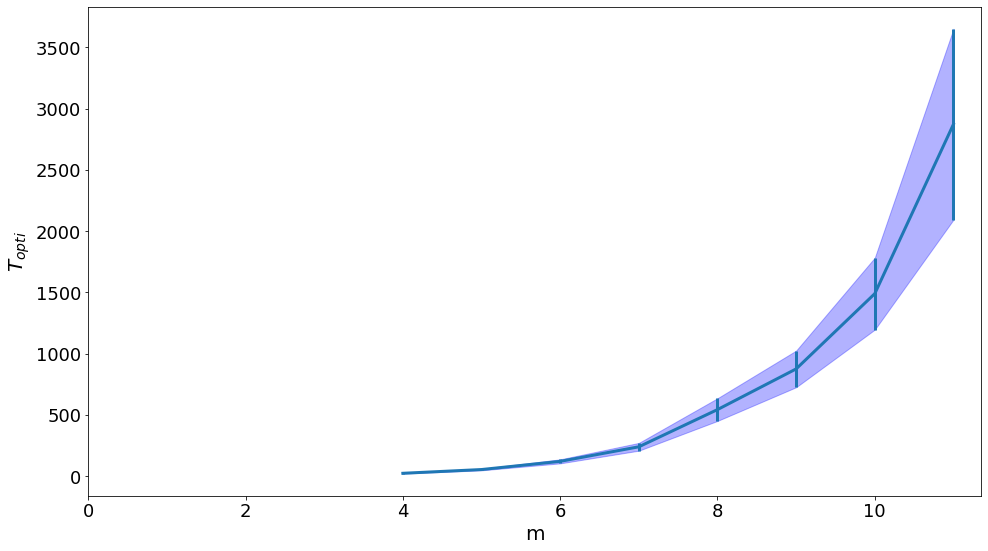

In [15]:
Average_time = np.mean(distrib_first_optimal, axis =1)
std = np.std(distrib_first_optimal, axis =1)/np.sqrt(n_trial)

plt.figure('Average Time',figsize = (16,9))
plt.clf()
plt.errorbar(ms, Average_time, std, linewidth=3)
plt.fill_between(ms,Average_time - std, Average_time + std , color='b', alpha=.3)


plt.xlim(xmin=0)

#plt.title("Average time the optimal decision is played for the first time in function of d",fontsize=20)
plt.ylabel(r'$T_{opti}$', fontsize=20)
plt.xlabel('m', fontsize=20)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)

plt.savefig(experimentfolder +"\\Averagel{}.pdf".format(n_init))

## Unfixed delta

m =  6
begin_trial 0
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000

Have still not played the optimal arm at time 90000
Have still not played the optimal arm at time 92000
Have still not played the optimal arm at time 94000
Have still not played the optimal arm at time 96000
Have still not played the optimal arm at time 98000
Have still not played the optimal arm at time 100000
Have still not played the optimal arm at time 102000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not

Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played

Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still n

Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played t

Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played 

Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 78000
Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 82000
Have still n

Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 78000
Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 82000
Have still not played the optimal arm at time 84000
Have still not played the optimal arm at time 86000
Have still not played the optimal arm at time 88000
Have still not played the optimal arm at time 90000
Have still not played the optimal arm at time 92000
Have still not played the optimal arm at time 94000
Have still not played the optimal arm at time 96000
Have still not played the optimal arm at time 98000
Have still n

Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not p

Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still not played the optimal arm at time 74000
Have still not played the optimal arm at time 76000
Have still not played the optimal arm at time 78000
Have still not played the optimal arm at time 80000
Have still not played the optimal arm at time 82000
Have still not played the optimal arm at time 84000
Have still not played the optimal arm at time 86000
Have still not played the optimal arm at time 88000
Have still not played the optimal arm at time 90000
Have still not played the optimal arm at time 92000
Have still not played the optimal arm at time 94000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not 

Have still not played the optimal arm at time 130000
Have still not played the optimal arm at time 132000
Have still not played the optimal arm at time 134000
Have still not played the optimal arm at time 136000
Have still not played the optimal arm at time 138000
Have still not played the optimal arm at time 140000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not pla

Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not 

Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still n

Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not p

Have still not played the optimal arm at time 136000
Have still not played the optimal arm at time 138000
Have still not played the optimal arm at time 140000
Have still not played the optimal arm at time 142000
Have still not played the optimal arm at time 144000
Have still not played the optimal arm at time 146000
Have still not played the optimal arm at time 148000
Have still not played the optimal arm at time 150000
Have still not played the optimal arm at time 152000
Have still not played the optimal arm at time 154000
Have still not played the optimal arm at time 156000
Have still not played the optimal arm at time 158000
Have still not played the optimal arm at time 160000
Have still not played the optimal arm at time 162000
Have still not played the optimal arm at time 164000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
H

Have still not played the optimal arm at time 36000
Have still not played the optimal arm at time 38000
Have still not played the optimal arm at time 40000
Have still not played the optimal arm at time 42000
Have still not played the optimal arm at time 44000
Have still not played the optimal arm at time 46000
Have still not played the optimal arm at time 48000
Have still not played the optimal arm at time 50000
Have still not played the optimal arm at time 52000
Have still not played the optimal arm at time 54000
Have still not played the optimal arm at time 56000
Have still not played the optimal arm at time 58000
Have still not played the optimal arm at time 60000
Have still not played the optimal arm at time 62000
Have still not played the optimal arm at time 64000
Have still not played the optimal arm at time 66000
Have still not played the optimal arm at time 68000
Have still not played the optimal arm at time 70000
Have still not played the optimal arm at time 72000
Have still n

Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not pl

Have still not played the optimal arm at time 82000
Have still not played the optimal arm at time 84000
Have still not played the optimal arm at time 86000
Have still not played the optimal arm at time 88000
Have still not played the optimal arm at time 90000
Have still not played the optimal arm at time 92000
Have still not played the optimal arm at time 94000
Have still not played the optimal arm at time 96000
Have still not played the optimal arm at time 98000
Have still not played the optimal arm at time 100000
Have still not played the optimal arm at time 102000
Have still not played the optimal arm at time 104000
Have still not played the optimal arm at time 106000
Have still not played the optimal arm at time 108000
Have still not played the optimal arm at time 110000
Have still not played the optimal arm at time 112000
Have still not played the optimal arm at time 114000
Have still not played the optimal arm at time 116000
Have still not played the optimal arm at time 118000
Ha

Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not play

Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the

Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
m =  4
begin_trial 0
begin_trial 100
begin_trial 200
begin_trial 300
begin_trial 400
begin_trial 500
begin_trial 600
begin_trial 700
begin_trial 800
begin_trial 900


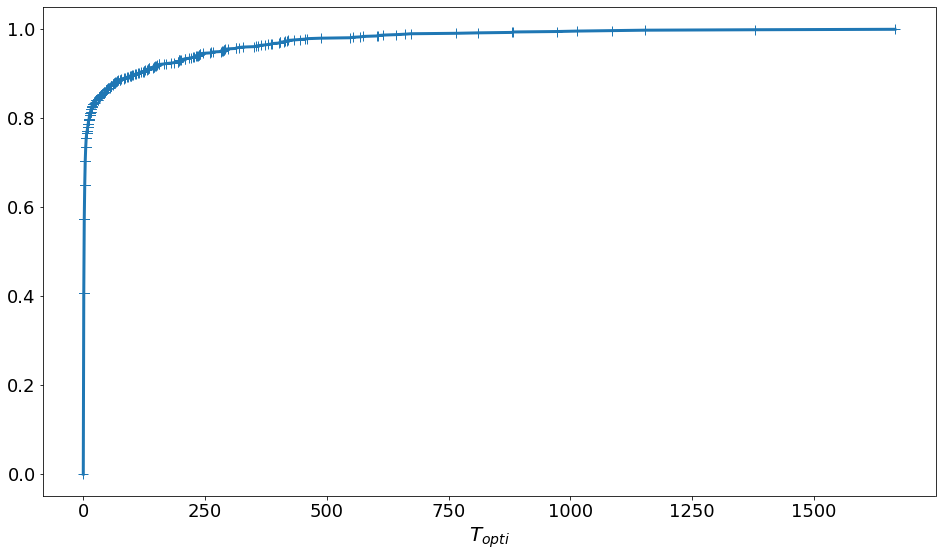

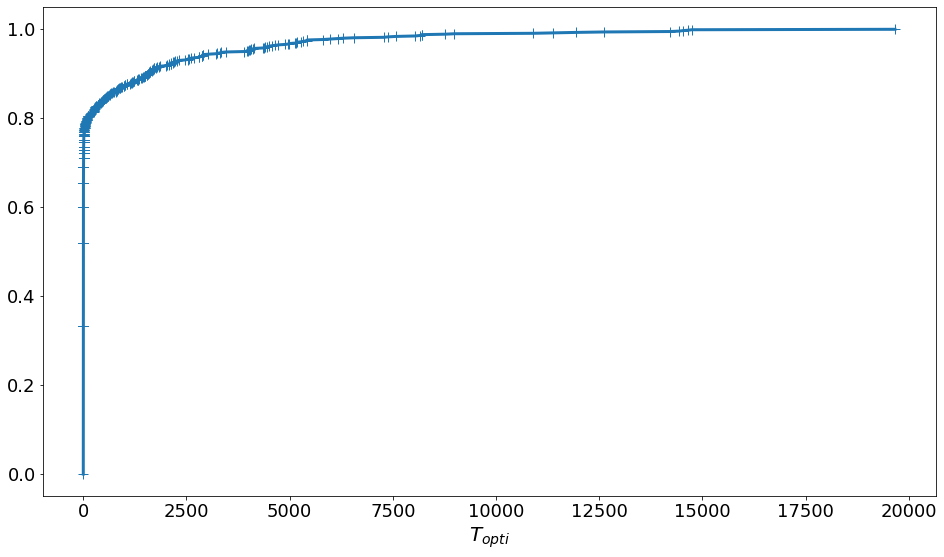

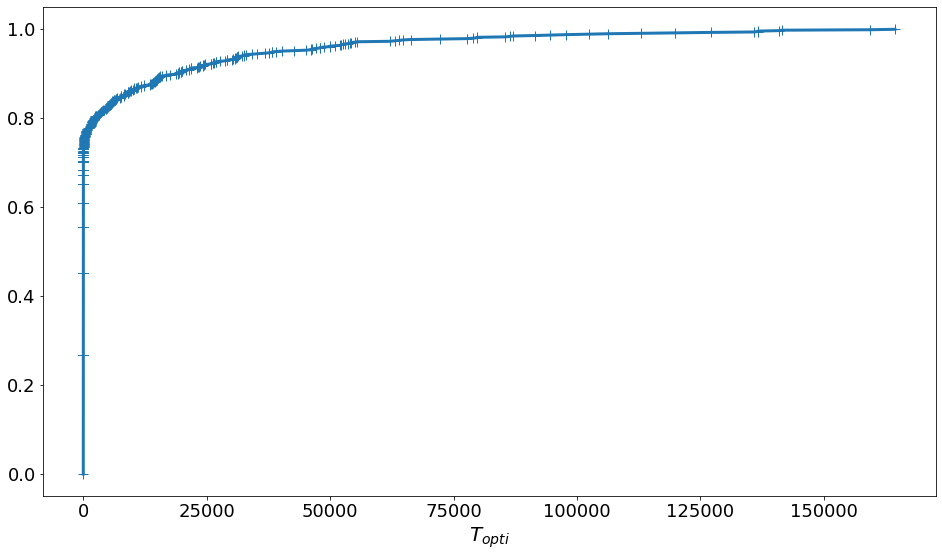

In [21]:
# testing the first time optimal is played

# Params
jump = 1
ms = list(range(4,7,jump))
n_trial = 1000 
n_init = 0
random_variable = "bernoulli"
post_distrib = "beta"

Param_dict = {}

Param_dict["ms"] = ms
Param_dict["n_trial"] = n_trial
Param_dict["random_variable"] = random_variable
Param_dict["post_distrib"] = post_distrib

upper_limit = 20000000

# Save Folder
experimentfolder = "Experience_opti_{}_{}_{}_Delta0.5".format(ms[0],ms[-1],jump)

if not os.path.exists(experimentfolder):
    os.makedirs(experimentfolder)

f = open(experimentfolder + "\\params.pkl","wb")
pickle.dump(Param_dict,f)
f.close()

distrib_first_optimal = [[] for m in ms]


for i,m in enumerate(ms[::-1]):
    print("m = ",m)
    optimal_arm = np.concatenate([np.arange(m)[:,None],np.arange(m)[:,None]],axis = 1)
    delta = 1/(2*m)
    for iteration in range(n_trial):
        if iteration%100 == 0:
            print("begin_trial {}".format(iteration))

        optimal_arm_played = False

        env = zgraph(m, delta = delta)
        player = zCThompson_sampling(m,n_init = n_init)

        counter = 0
        while player.initialization:
                decision = player.play()
                reward_dict, regret = env.draw(decision)
                player.update(reward_dict)
        
        while not optimal_arm_played and counter < upper_limit:
                decision = player.play()
                reward_dict, regret = env.draw(decision)
                player.update(reward_dict)
                counter += 1

                if counter%2000 == 0:
                    print("Have still not played the optimal arm at time {}".format(counter))
                    
                if (decision == optimal_arm).all():
                    optimal_arm_played = True
                    
        distrib_first_optimal[-(i+1)].append(counter)

np.save(experimentfolder +"\\Distribution",distrib_first_optimal)

#plot Result ECDF

for i,m in enumerate(ms):
    plt.figure(i,figsize = (16,9))
    plt.clf()
    cdf = ECDF(distrib_first_optimal[i])
    plt.plot([0]+list(np.sort(distrib_first_optimal[i])),[0]+list(cdf(np.sort(distrib_first_optimal[i]))),"+-",linewidth=3,markersize=10)
#plt.title("Distribution of first optimal play  for b = {:.1f} and d = {:d} ".format(b,d),fontsize=20)   
    plt.xlabel(r'$T_{opti}$', fontsize=20)
    plt.tick_params(axis='x', labelsize=18)
    plt.tick_params(axis='y', labelsize=18)
    
    plt.savefig(experimentfolder+'\\ECDF_m{}_l{}.pdf'.format(m,n_init))

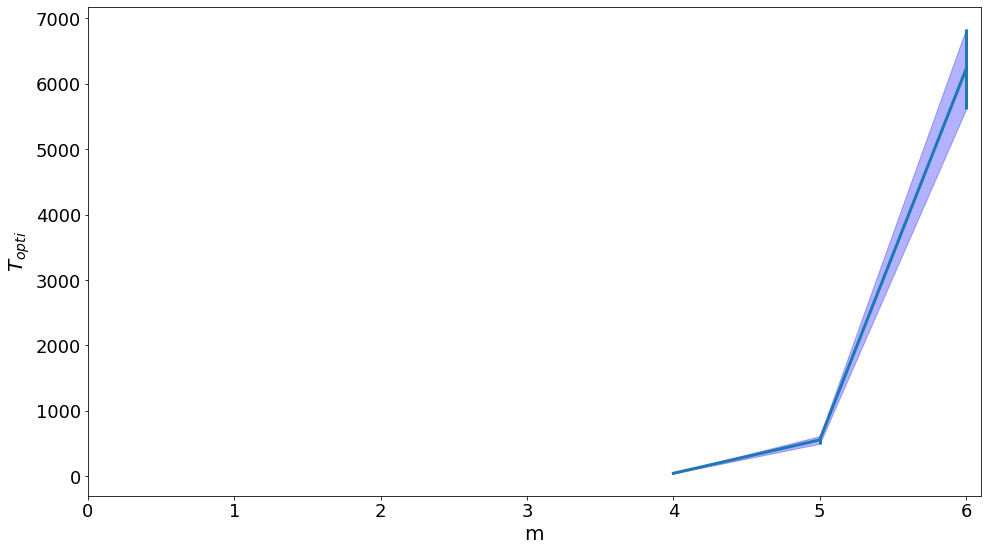

In [22]:
Average_time = np.mean(distrib_first_optimal, axis =1)
std = np.std(distrib_first_optimal, axis =1)/np.sqrt(n_trial)

plt.figure('Average Time',figsize = (16,9))
plt.clf()
plt.errorbar(ms, Average_time, std, linewidth=3)
plt.fill_between(ms,Average_time - std, Average_time + std , color='b', alpha=.3)


plt.xlim(xmin=0)

#plt.title("Average time the optimal decision is played for the first time in function of d",fontsize=20)
plt.ylabel(r'$T_{opti}$', fontsize=20)
plt.xlabel('m', fontsize=20)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)

plt.savefig(experimentfolder +"\\Averagel{}.pdf".format(n_init))

# Regret

## Fixed delta

In [58]:

# Params
jump = 1
ms = list(range(4,12,jump))
n_trial = 50 
delta = 0.01
n_init = 0
random_variable = "bernoulli"
post_distrib = "beta"

Param_dict = {}

Param_dict["ms"] = ms
Param_dict["n_trial"] = n_trial
Param_dict["delta"] = delta
Param_dict["random_variable"] = random_variable
Param_dict["post_distrib"] = post_distrib

upper_limit = 10000

# Save Folder
experimentfolder = "Experience_Regret_{}_{}_{}_delta{:.3f}".format(ms[0],ms[-1],jump,delta)

if not os.path.exists(experimentfolder):
    os.makedirs(experimentfolder)

f = open(experimentfolder + "\\params.pkl","wb")
pickle.dump(Param_dict,f)
f.close()



### TS

In [59]:
regrets = np.zeros((len(ms),n_trial,upper_limit))

for i,m in enumerate(ms):
    print("m = ",m)
    
    for iteration in range(n_trial):

        env = zgraph(m, delta = delta)
        player = zCThompson_sampling(m,n_init = n_init)

        counter = 0
    
        
        while counter < upper_limit:
                decision = player.play()
                reward_dict, regret = env.draw(decision)
                player.update(reward_dict)
                
                regrets[i,iteration,counter] = regret
                
                counter += 1
                if counter%5000 == 0:
                    print("play number {}".format(counter))
                    
cumulative_regrets = np.cumsum(regrets, axis = 2)
        


m =  4
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5

play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
m =  9
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 1

C:\Users\Rzhang\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
C:\Users\Rzhang\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
C:\Users\Rzhang\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
C:\Users\Rzhang\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
C:\Users\Rzhang\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
C:\Users\Rzhang\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
C:\Users\Rzhang\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: 

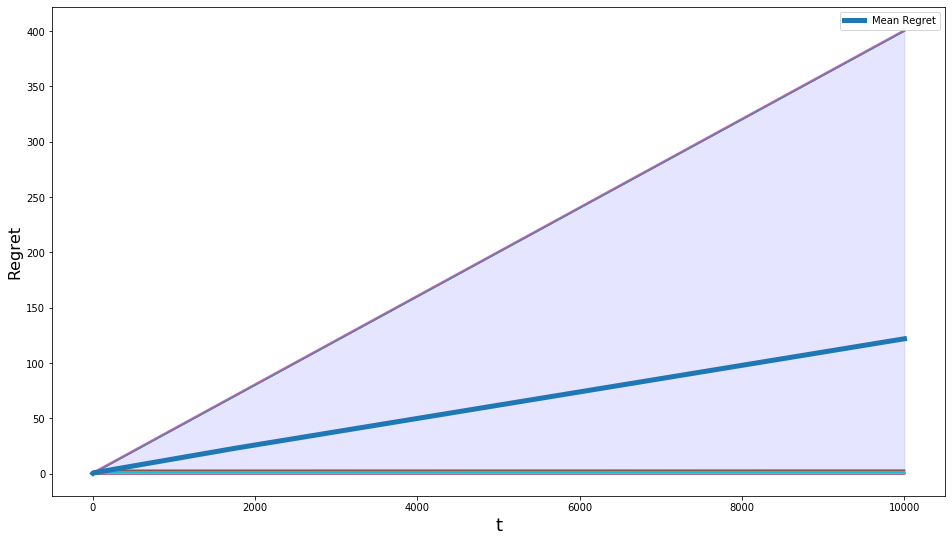

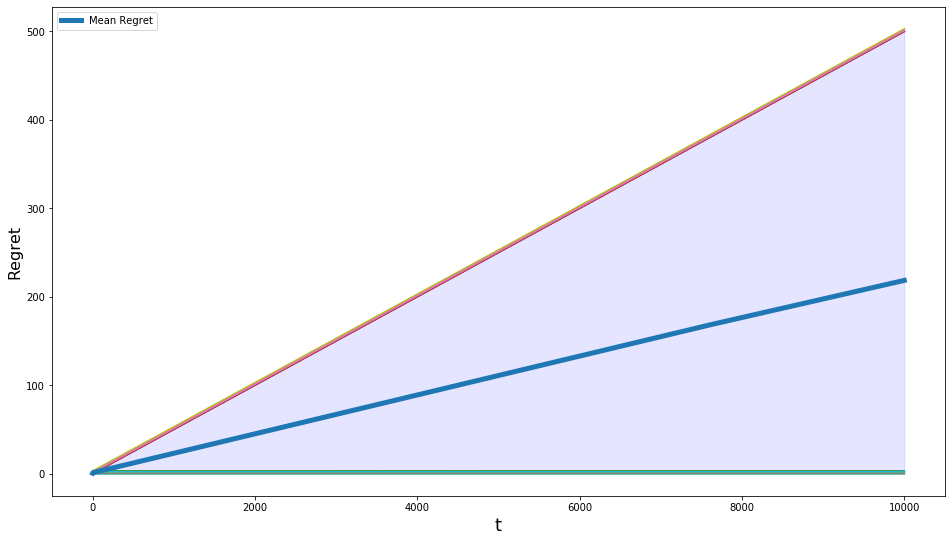

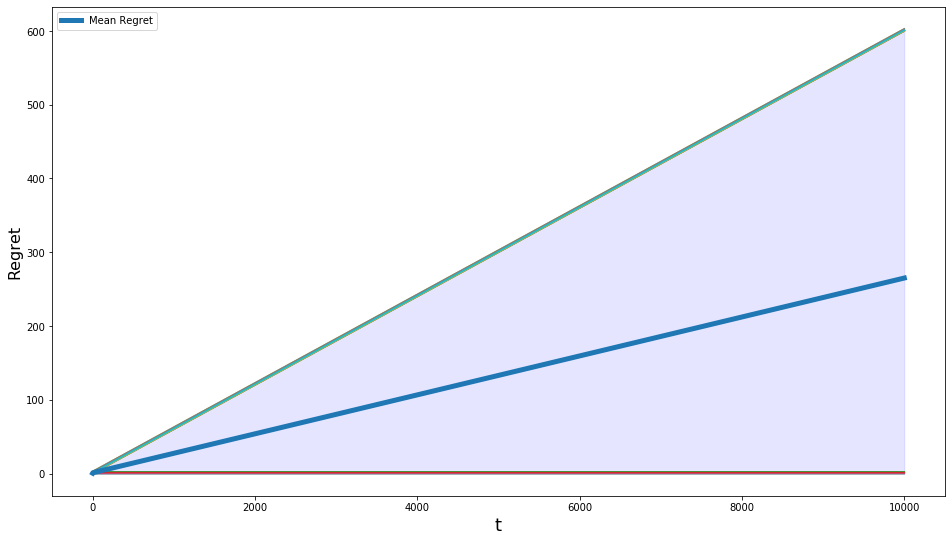

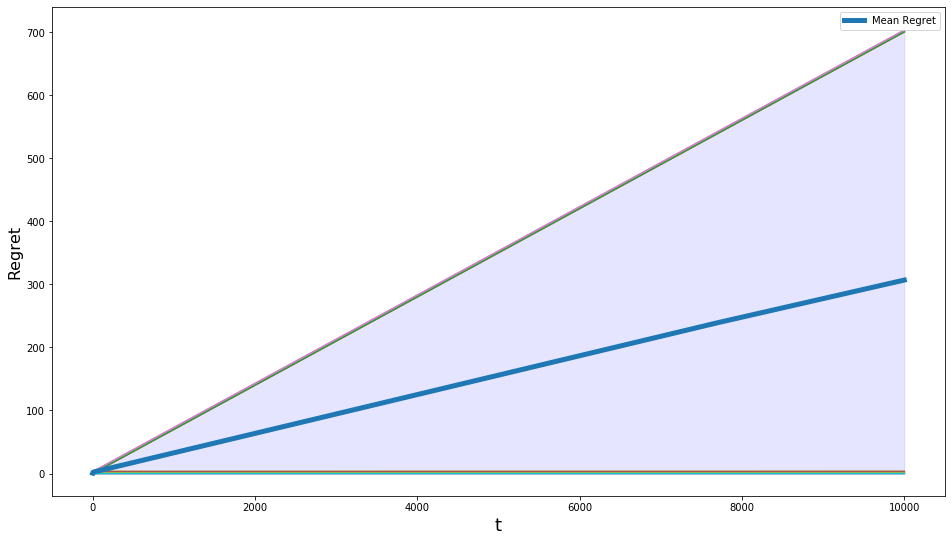

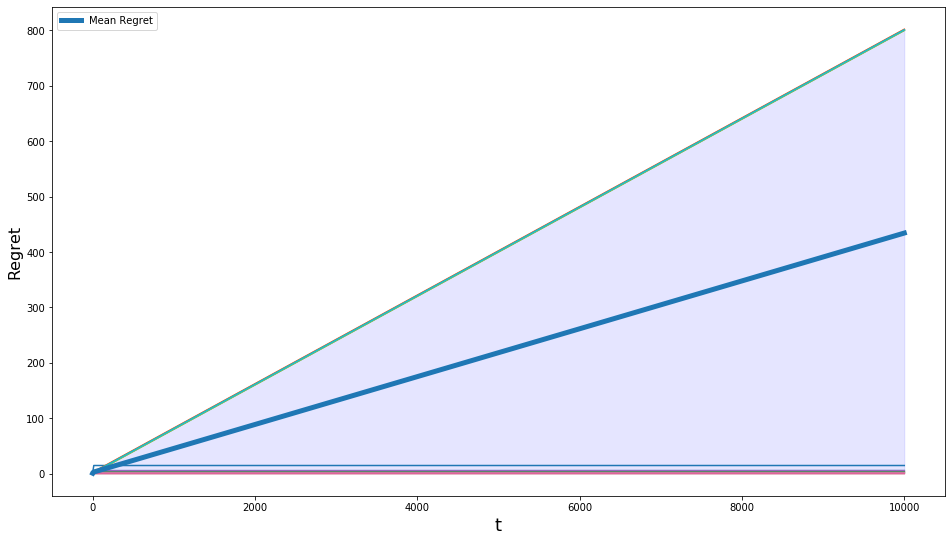

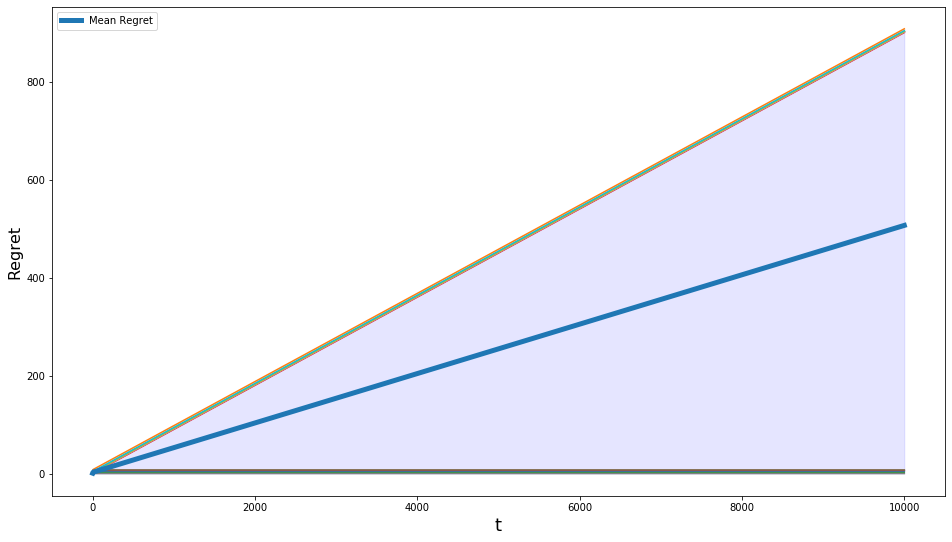

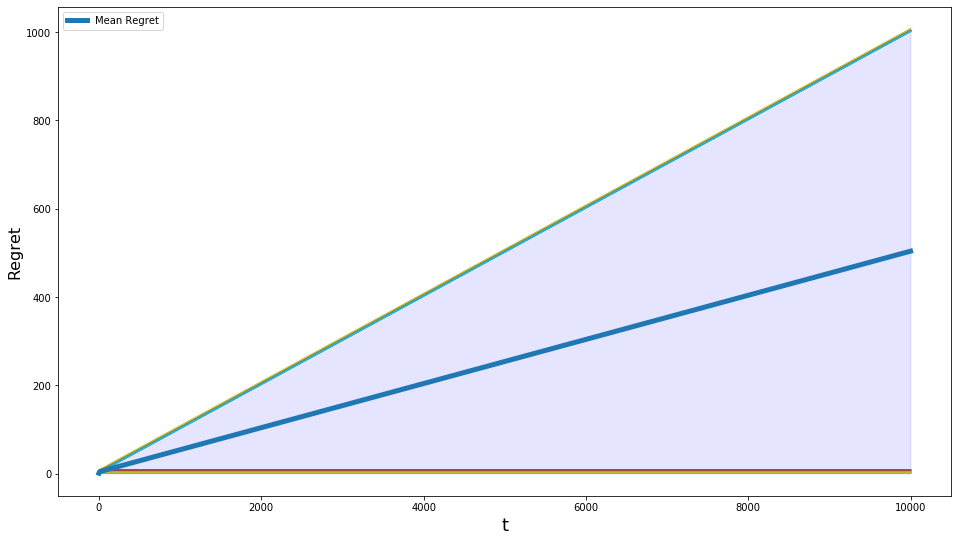

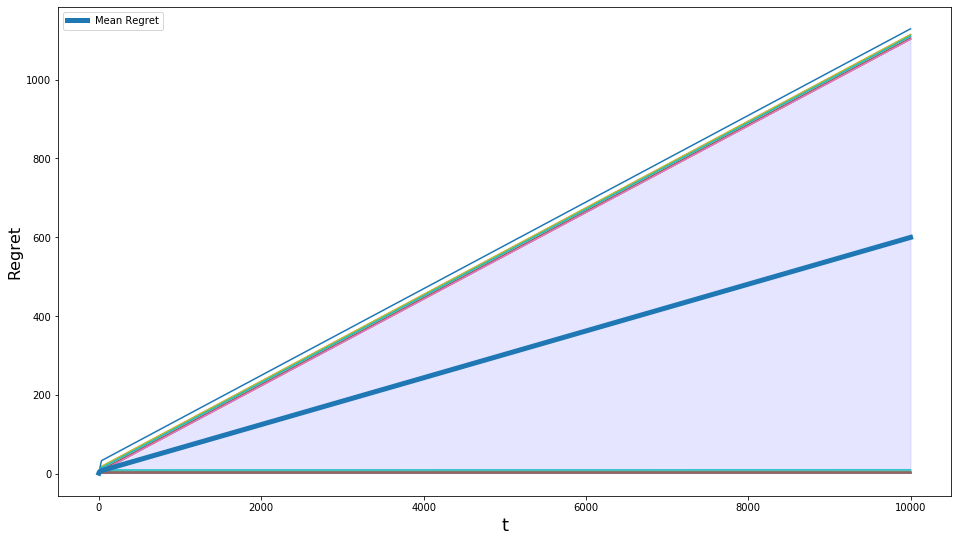

In [60]:
for i,m in enumerate(ms):
    plt.figure(i,figsize = (16,9))
    plt.clf()
    #plt.title(" m = {} , b = {:.4f}".format(m,b), fontsize=20)
    for k in np.random.randint(0,n_trial,20):
        plt.plot(cumulative_regrets[i,k,::])
    plt.plot(np.mean(cumulative_regrets[i,::,::],axis = 0), label = "Mean Regret",linewidth=5)
    maxi95 = np.argsort(cumulative_regrets[i,::,-1])[int(n_trial*0.975)]
    maxi95 = cumulative_regrets[i,maxi95,::]
    
    mini95 = np.argsort(cumulative_regrets[i,::,-1])[int(n_trial*0.025)]
    mini95 = cumulative_regrets[i,mini95,::]
    
    plt.fill_between(range(upper_limit),mini95,maxi95, color='b', alpha=.1)
    
    plt.xlabel('t', fontsize=18)
    plt.ylabel('Regret', fontsize=16)
    plt.legend()
    plt.savefig(experimentfolder+'\\TS_regret_m{}_l{}.pdf'.format(m,0))

### CUCB

In [61]:
regrets = np.zeros((len(ms),n_trial,upper_limit))

for i,m in enumerate(ms):
    print("m = ",m)
    
    for iteration in range(n_trial):

        env = zgraph(m, delta = delta)
        player = zCUCB(m,n_init = 1)

        counter = 0
    
        
        while counter < upper_limit:
                decision = player.play()
                reward_dict, regret = env.draw(decision)
                player.update(reward_dict)
                
                regrets[i,iteration,counter] = regret
                
                counter += 1
                if counter%5000 == 0:
                    print("play number {}".format(counter))
                    
cumulative_regrets = np.cumsum(regrets, axis = 2)
        


m =  4
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5

play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
m =  9
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 1

C:\Users\Rzhang\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
C:\Users\Rzhang\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
C:\Users\Rzhang\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
C:\Users\Rzhang\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
C:\Users\Rzhang\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
C:\Users\Rzhang\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
C:\Users\Rzhang\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: 

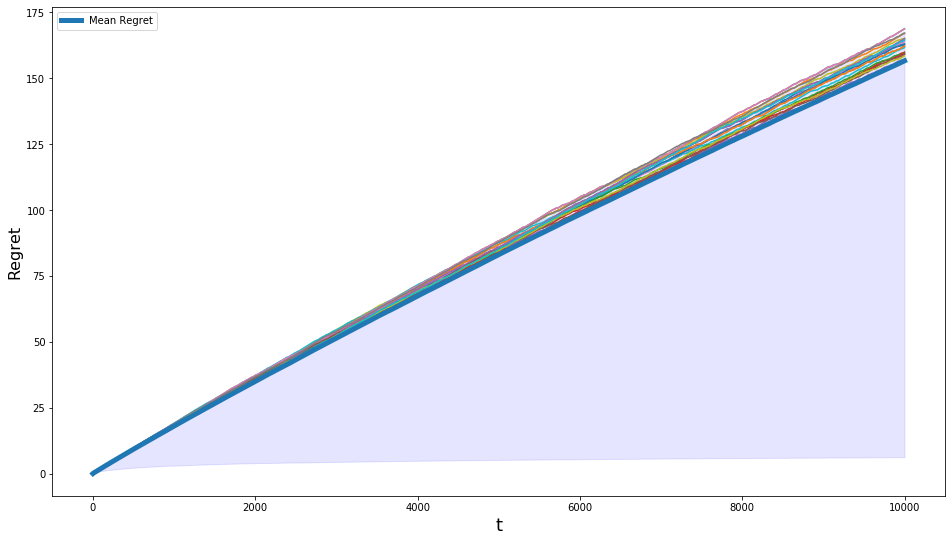

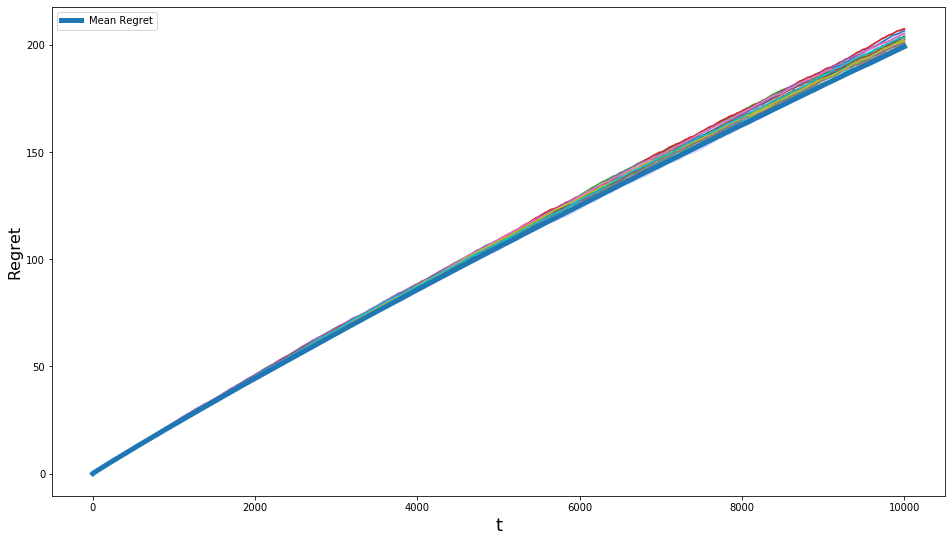

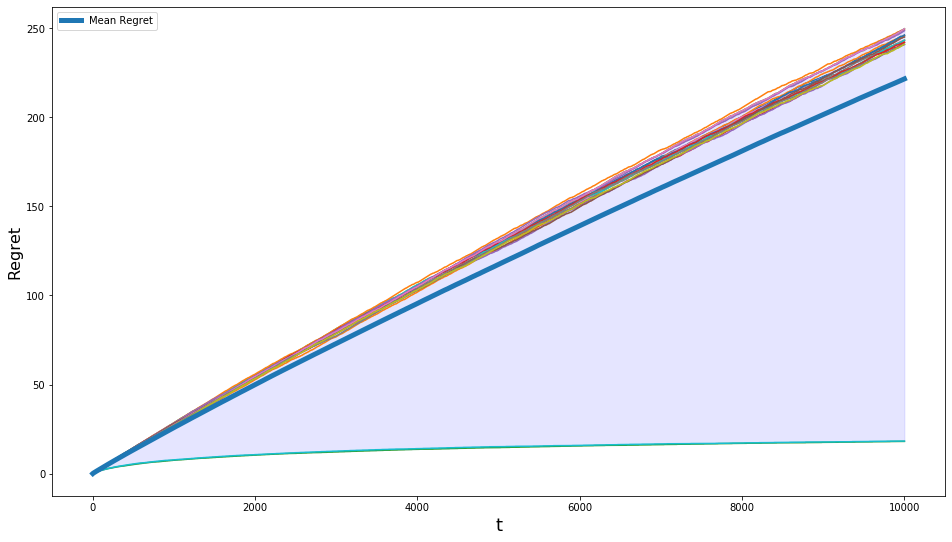

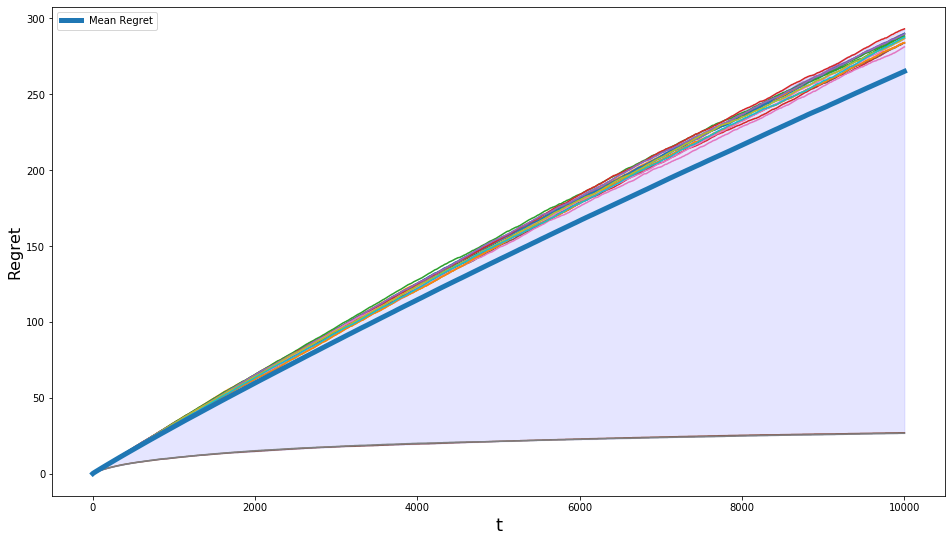

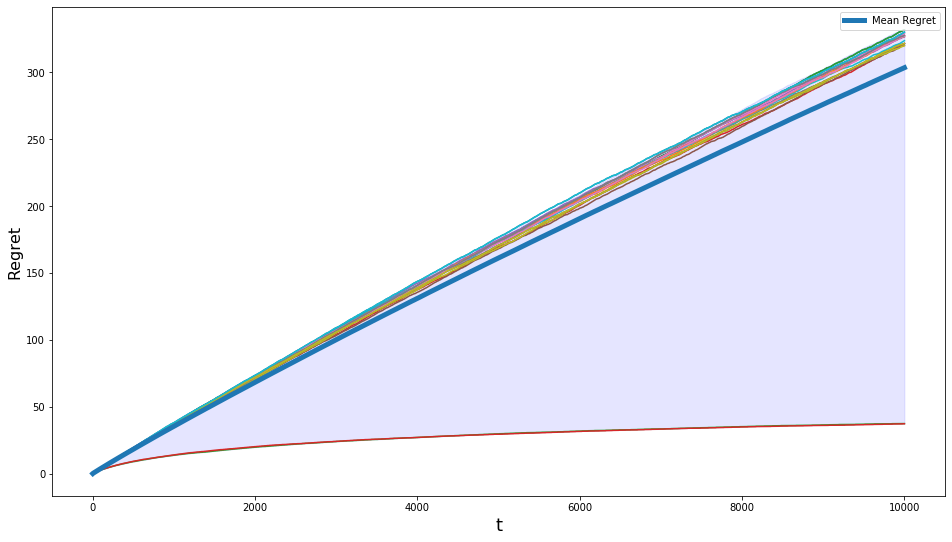

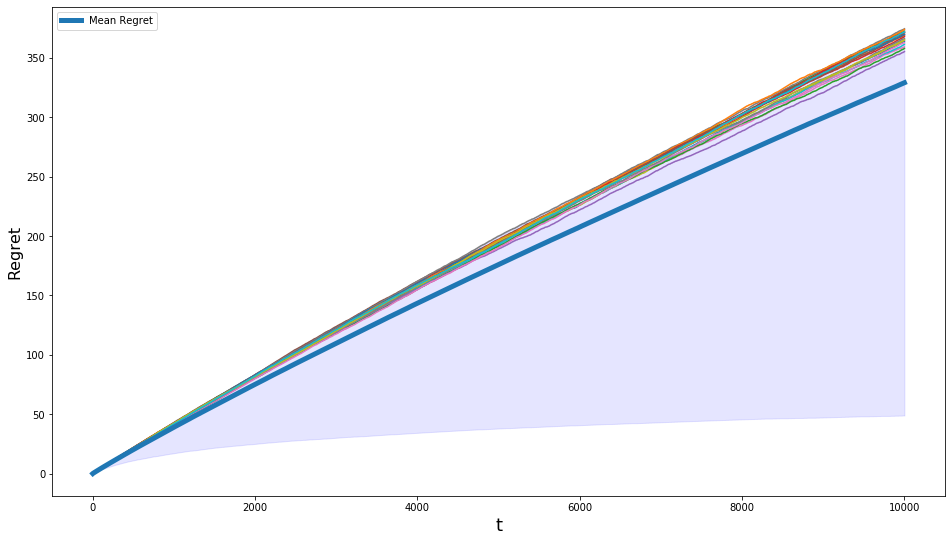

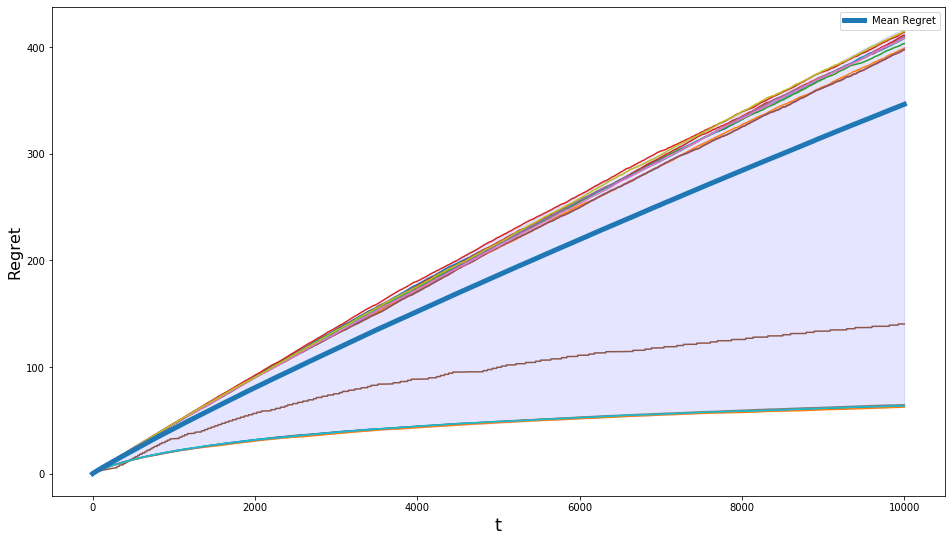

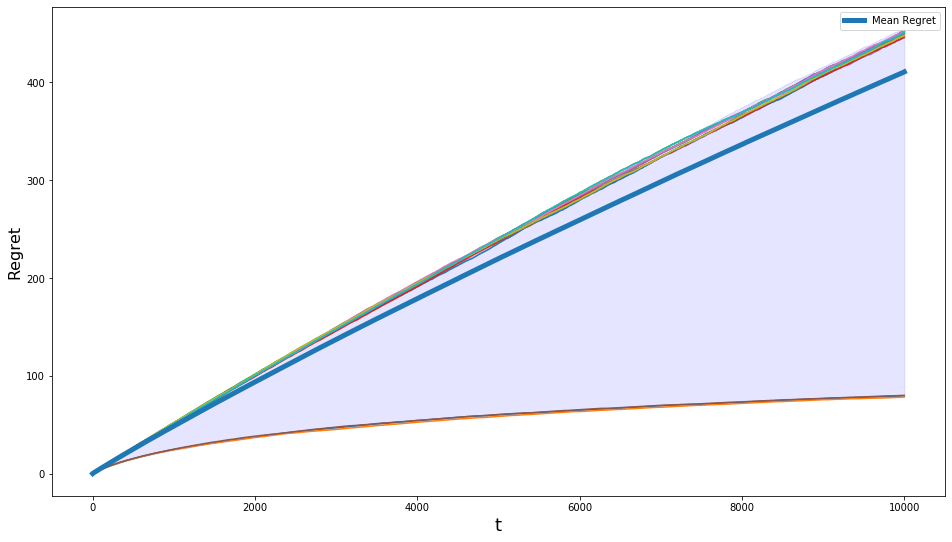

In [63]:
for i,m in enumerate(ms):
    plt.figure(i,figsize = (16,9))
    plt.clf()
    #plt.title(" m = {} , b = {:.4f}".format(m,b), fontsize=20)
    for k in np.random.randint(0,n_trial,20):
        plt.plot(cumulative_regrets[i,k,::])
    plt.plot(np.mean(cumulative_regrets[i,::,::],axis = 0), label = "Mean Regret",linewidth=5)
    maxi95 = np.argsort(cumulative_regrets[i,::,-1])[int(n_trial*0.975)]
    maxi95 = cumulative_regrets[i,maxi95,::]
    
    mini95 = np.argsort(cumulative_regrets[i,::,-1])[int(n_trial*0.025)]
    mini95 = cumulative_regrets[i,mini95,::]
    
    plt.fill_between(range(upper_limit),mini95,maxi95, color='b', alpha=.1)
    
    plt.xlabel('t', fontsize=18)
    plt.ylabel('Regret', fontsize=16)
    plt.legend()
    plt.savefig(experimentfolder+'\\CUCB_regret_m{}.pdf'.format(m))

## Unfixed delta

In [48]:
# Params
jump = 1
ms = list(range(4,12,jump))
n_trial = 50 
n_init = 0
random_variable = "bernoulli"
post_distrib = "beta"

Param_dict = {}

Param_dict["ms"] = ms
Param_dict["n_trial"] = n_trial
Param_dict["delta"] = delta
Param_dict["random_variable"] = random_variable
Param_dict["post_distrib"] = post_distrib

upper_limit = 10000

# Save Folder
experimentfolder = "Experience_Regret_{}_{}_{}_Delta0.5".format(ms[0],ms[-1],jump)

if not os.path.exists(experimentfolder):
    os.makedirs(experimentfolder)

f = open(experimentfolder + "\\params.pkl","wb")
pickle.dump(Param_dict,f)
f.close()


### TS

In [49]:
regrets = np.zeros((len(ms),n_trial,upper_limit))

for i,m in enumerate(ms):
    print("m = ",m)
    delta = 1/(2*m)
    
    for iteration in range(n_trial):

        env = zgraph(m, delta = delta)
        player = zCThompson_sampling(m,n_init = n_init)

        counter = 0
    
        
        while counter < upper_limit:
                decision = player.play()
                reward_dict, regret = env.draw(decision)
                player.update(reward_dict)
                
                regrets[i,iteration,counter] = regret
                
                counter += 1
                if counter%5000 == 0:
                    print("play number {}".format(counter))
                    
cumulative_regrets = np.cumsum(regrets, axis = 2)
        

m =  4
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5

play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
m =  9
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 1

C:\Users\Rzhang\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
C:\Users\Rzhang\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
C:\Users\Rzhang\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
C:\Users\Rzhang\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
C:\Users\Rzhang\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
C:\Users\Rzhang\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
C:\Users\Rzhang\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: 

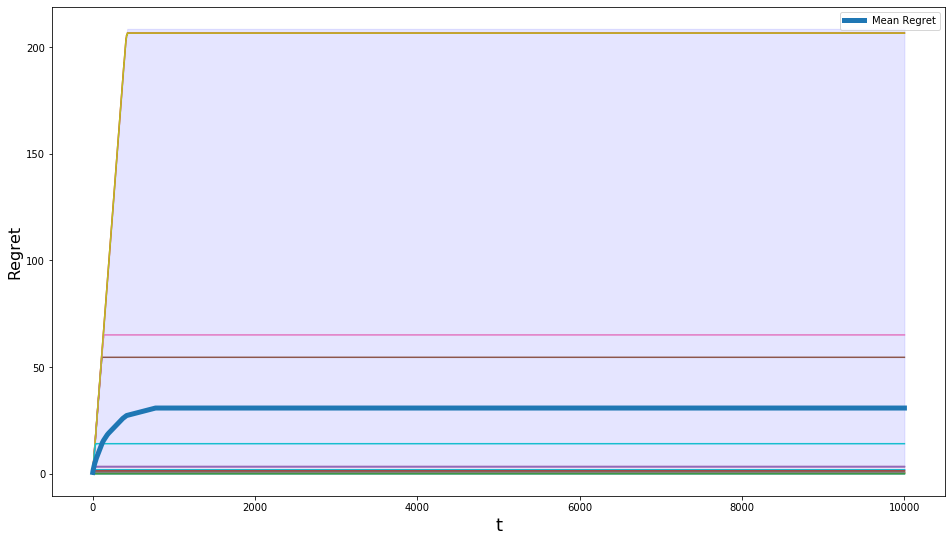

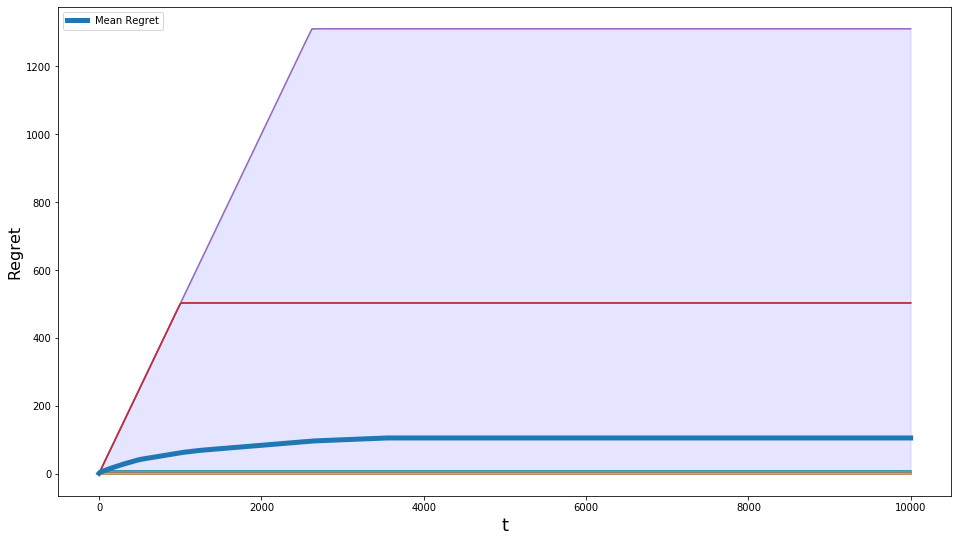

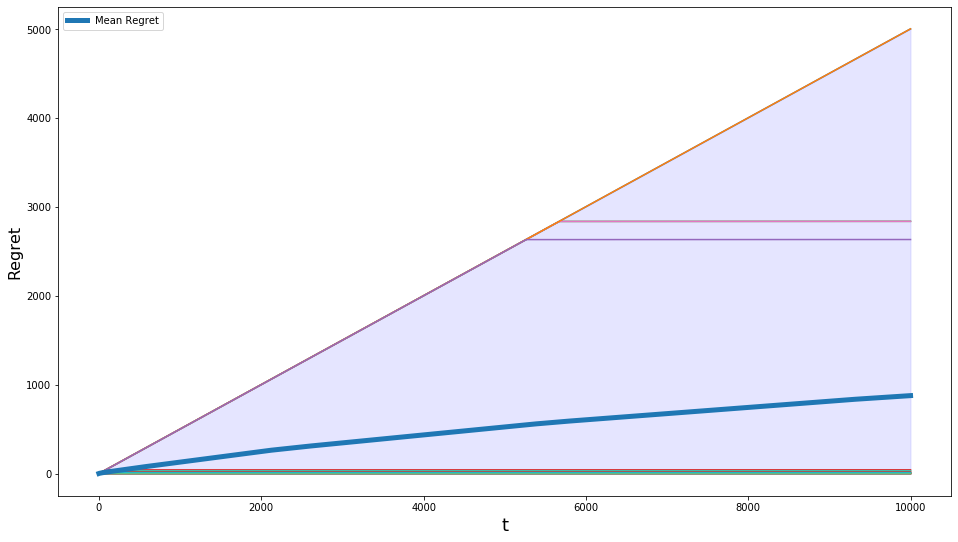

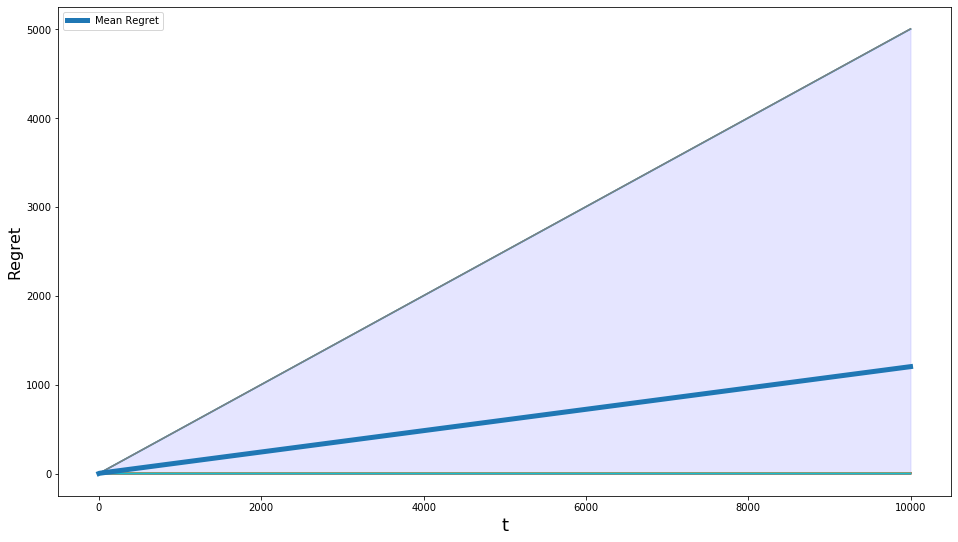

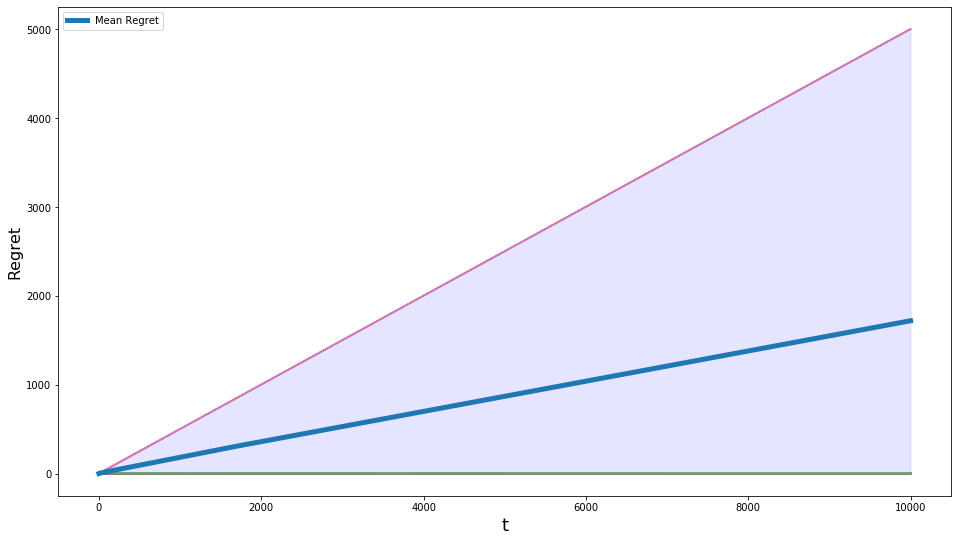

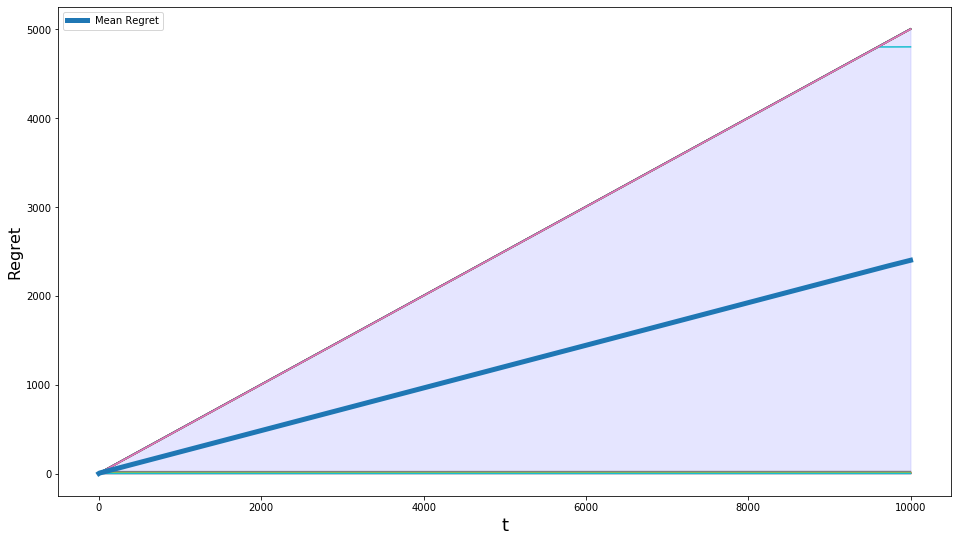

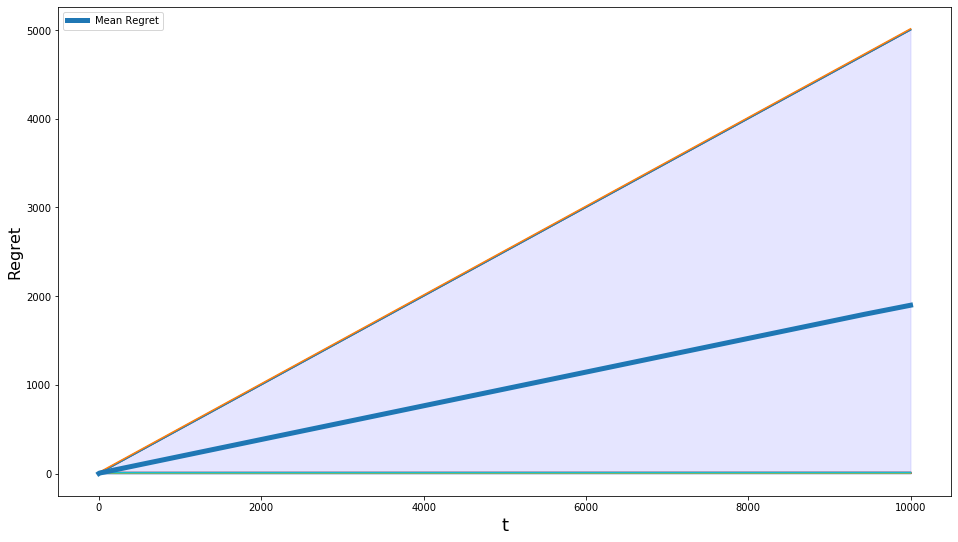

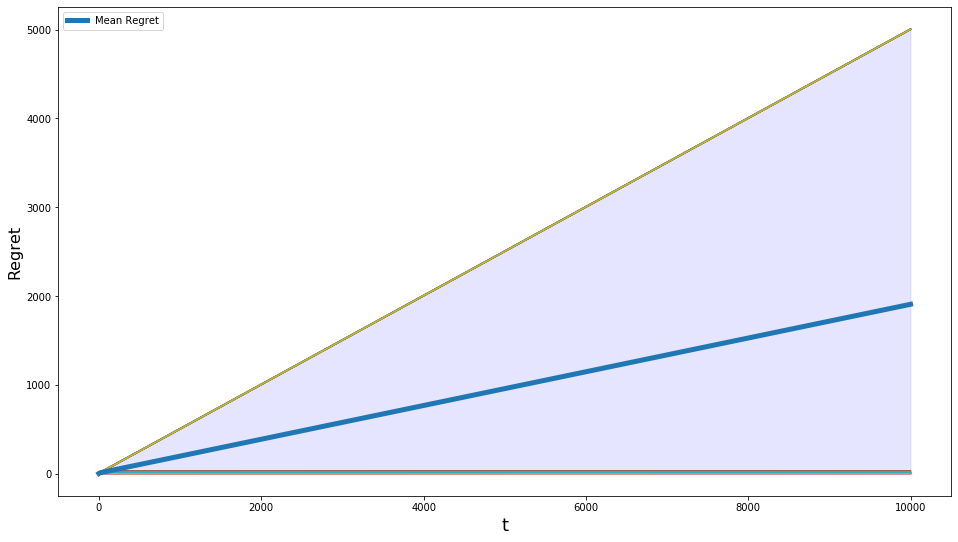

In [50]:
for i,m in enumerate(ms):
    plt.figure(i,figsize = (16,9))
    plt.clf()
    #plt.title(" m = {} , b = {:.4f}".format(m,b), fontsize=20)
    for k in np.random.randint(0,n_trial,20):
        plt.plot(cumulative_regrets[i,k,::])
    plt.plot(np.mean(cumulative_regrets[i,::,::],axis = 0), label = "Mean Regret",linewidth=5)
    maxi95 = np.argsort(cumulative_regrets[i,::,-1])[int(n_trial*0.975)]
    maxi95 = cumulative_regrets[i,maxi95,::]
    
    mini95 = np.argsort(cumulative_regrets[i,::,-1])[int(n_trial*0.025)]
    mini95 = cumulative_regrets[i,mini95,::]
    
    plt.fill_between(range(upper_limit),mini95,maxi95, color='b', alpha=.1)
    
    plt.xlabel('t', fontsize=18)
    plt.ylabel('Regret', fontsize=16)
    plt.legend()
    plt.savefig(experimentfolder+'\\TS_regret_m{}_l{}.pdf'.format(m,0))

### CUCB

In [51]:
regrets = np.zeros((len(ms),n_trial,upper_limit))

for i,m in enumerate(ms):
    print("m = ",m)
    delta = 1/(2*m)
    for iteration in range(n_trial):

        env = zgraph(m, delta = delta)
        player = zCUCB(m,n_init = 1)

        counter = 0
    
        
        while counter < upper_limit:
                decision = player.play()
                reward_dict, regret = env.draw(decision)
                player.update(reward_dict)
                
                regrets[i,iteration,counter] = regret
                
                counter += 1
                if counter%5000 == 0:
                    print("play number {}".format(counter))
                    
cumulative_regrets = np.cumsum(regrets, axis = 2)
        

m =  4
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5

play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
m =  9
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 10000
play number 5000
play number 1

C:\Users\Rzhang\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
C:\Users\Rzhang\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
C:\Users\Rzhang\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
C:\Users\Rzhang\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
C:\Users\Rzhang\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
C:\Users\Rzhang\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
C:\Users\Rzhang\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: 

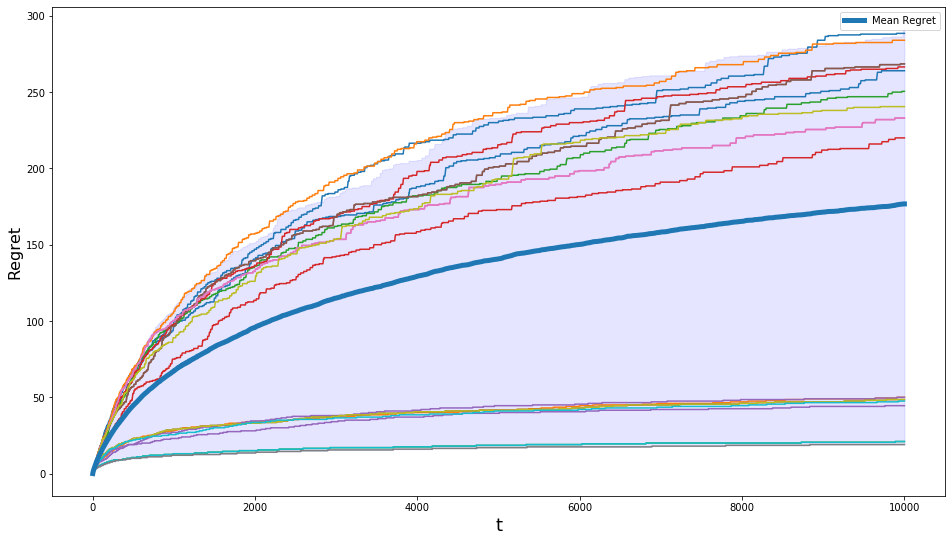

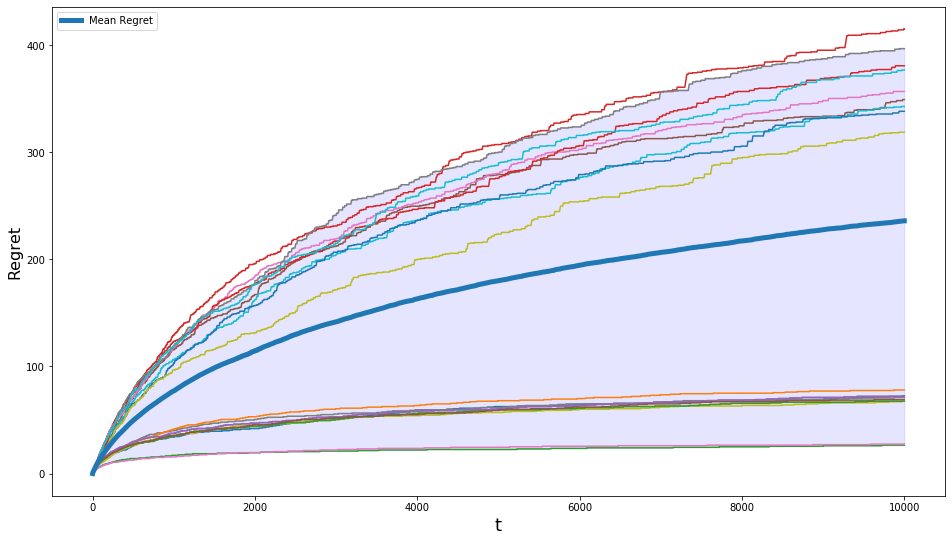

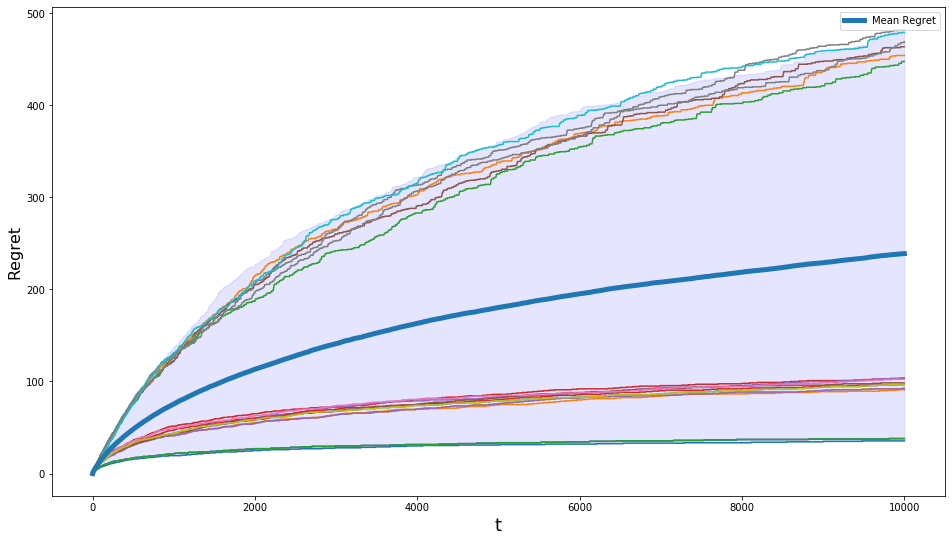

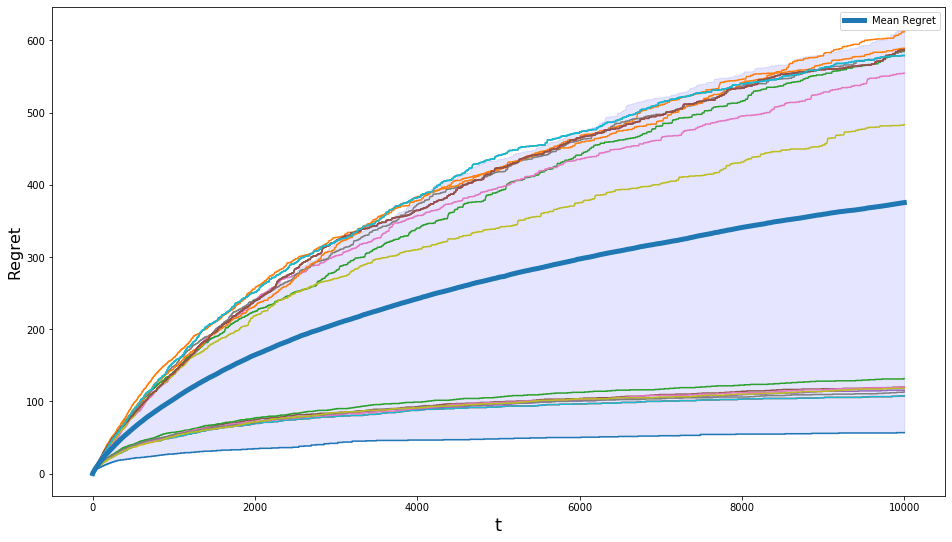

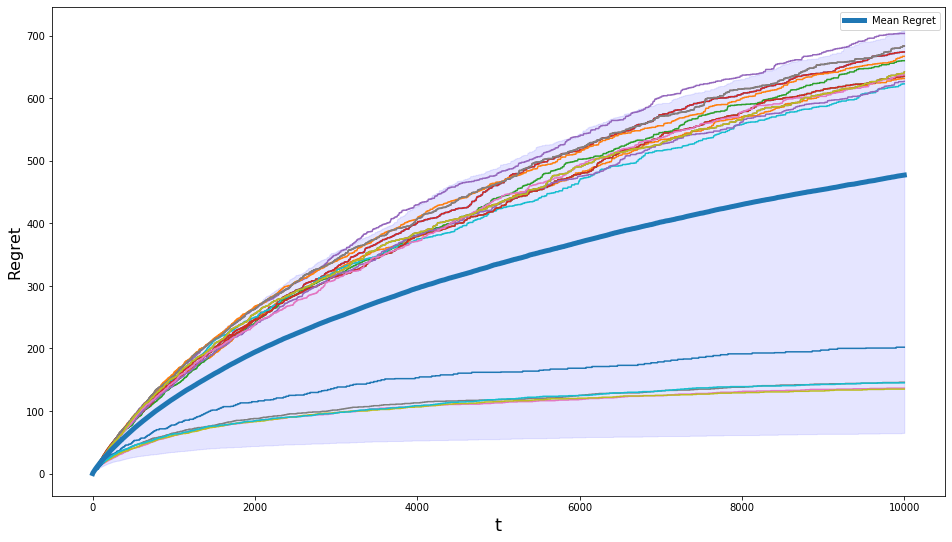

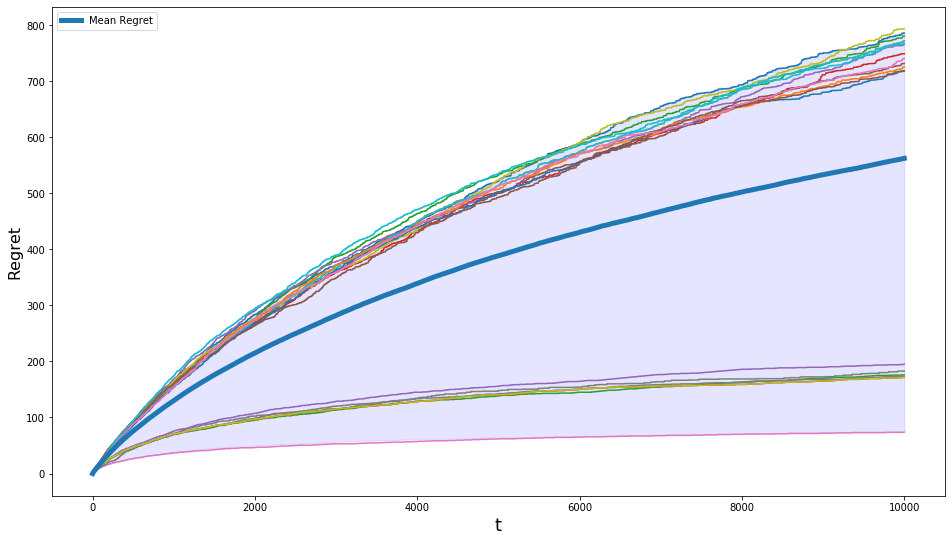

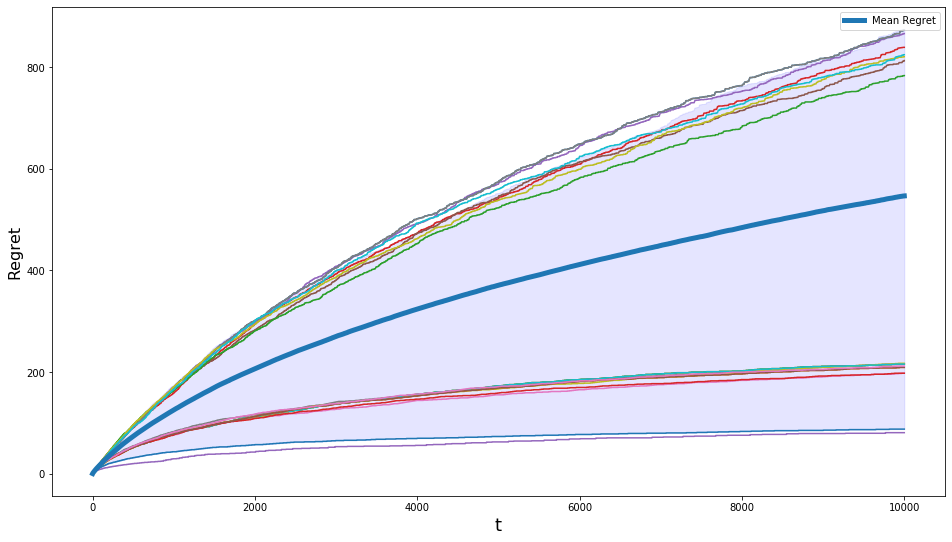

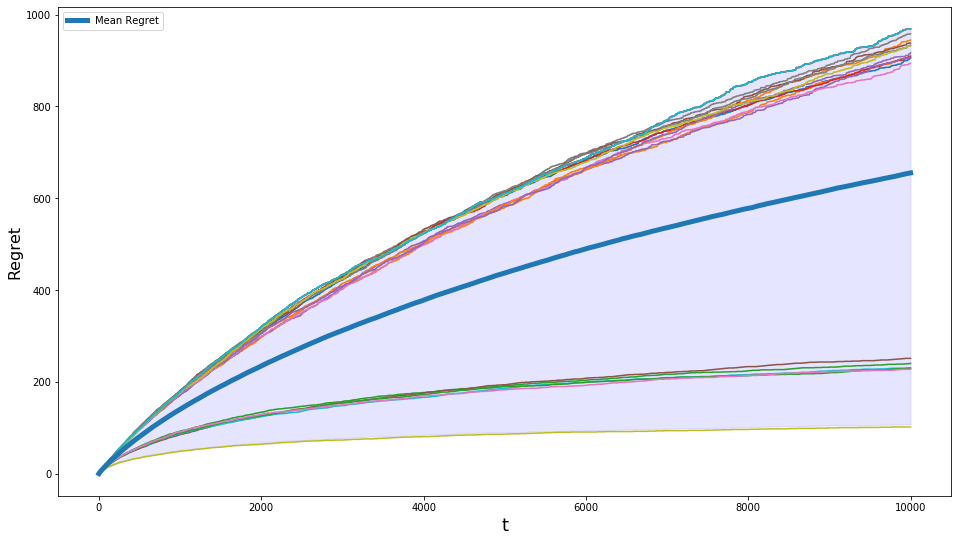

In [52]:
for i,m in enumerate(ms):
    plt.figure(i,figsize = (16,9))
    plt.clf()
    #plt.title(" m = {} , b = {:.4f}".format(m,b), fontsize=20)
    for k in np.random.randint(0,n_trial,20):
        plt.plot(cumulative_regrets[i,k,::])
    plt.plot(np.mean(cumulative_regrets[i,::,::],axis = 0), label = "Mean Regret",linewidth=5)
    maxi95 = np.argsort(cumulative_regrets[i,::,-1])[int(n_trial*0.975)]
    maxi95 = cumulative_regrets[i,maxi95,::]
    
    mini95 = np.argsort(cumulative_regrets[i,::,-1])[int(n_trial*0.025)]
    mini95 = cumulative_regrets[i,mini95,::]
    
    plt.fill_between(range(upper_limit),mini95,maxi95, color='b', alpha=.1)
    
    plt.xlabel('t', fontsize=18)
    plt.ylabel('Regret', fontsize=16)
    plt.legend()
    plt.savefig(experimentfolder+'\\CUCB_regret_m{}.pdf'.format(m))